In [1]:
import gc
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, RandomSimetry, ImMean as IM, ImSTD as IS
from Network import ASPP_Unet, ssim_loss, ConvolutionBlock, ASPP

path = "/home/danilo/SSD/FGV/" + "triple_data/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
#df_z = df[df["mean"] < 0.2].sample(frac=0.2)
#df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
0,-3.89,-54.48,2016,8,1,0.0,Labeled_-3.89_-54.48_2016_08_01_0.0.npy
1,-4.19,-54.92,2020,6,1,0.0,Labeled_-4.19_-54.92_2020_06_01_0.0.npy
2,-4.23,-54.90,2019,7,1,0.0,Labeled_-4.23_-54.90_2019_07_01_0.0.npy
3,-3.65,-54.98,2019,7,1,0.0,Labeled_-3.65_-54.98_2019_07_01_0.0.npy
4,-3.75,-54.62,2020,8,1,0.0,Labeled_-3.75_-54.62_2020_08_01_0.0.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomRotation(360),
            transforms.RandomCrop((64,64)),
            transforms.Normalize(IM, IS),
            RandomSimetry(),
        ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(1252, 313)

In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

tensor([ 0.2664,  0.2890, -0.0984,  0.3409,  0.1049,  0.3799,  0.5179, -0.1312,
        -0.0302, -0.0123, -0.4038,  0.0340, -0.2675,  0.0889,  0.1889,  0.3697,
         0.1158,  0.1320, -0.2599,  0.1832, -0.0052,  0.2988,  0.4162,  0.2081],
       device='cuda:0')
tensor([1.0750, 1.0777, 1.0097, 1.0350, 1.6894, 1.3425, 1.1170, 0.9914, 0.8324,
        0.8376, 0.8046, 0.8310, 1.4085, 1.1514, 0.9541, 0.9291, 0.9441, 0.9425,
        0.8952, 0.9216, 1.4495, 1.2169, 1.1050, 0.9781], device='cuda:0')


In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            ConvolutionBlock(8, 8, kernel_size=3, residual=True),
            ConvolutionBlock(8, 8, kernel_size=3, residual=True),

            ASPP(8, 8),
        )
    
    def forward(self, x):
        return self.conv(x)

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = ImageEncoder()
        self.unet = ASPP_Unet(8*3, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 100000

        return x

    
model = Network().to(device)

In [5]:
Mean = df["mean"].mean()

bce_loss = nn.BCEWithLogitsLoss()
bce_ssim = lambda output, target: bce_loss(output, target) + 2 * ssim_loss(torch.sigmoid(output), target)

In [6]:
def plot_images():
    model.eval()

    im, lb = next(iter(val_dl))
    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label)
    axes[4].imshow(output)
    plt.show()

    model.train()

In [7]:
def f1_score(dl):
    model.eval()

    im, lb = next(iter(dl))

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?
    
    model.train()

    return float(f1), float(iou)

  0%|          | 0/10001 [00:00<?, ?it/s]

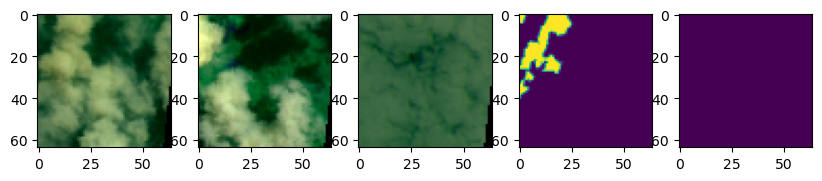

Loss: 1.1744:   1%|          | 100/10001 [00:18<20:38,  8.00it/s] 

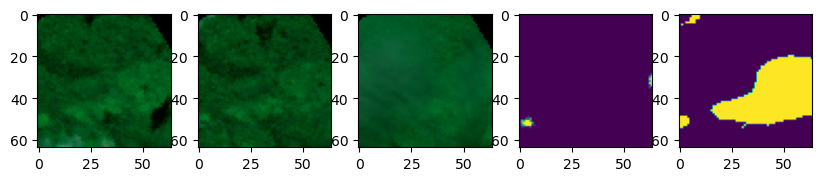

Loss: 1.0478:   2%|▏         | 200/10001 [00:36<20:33,  7.95it/s]  

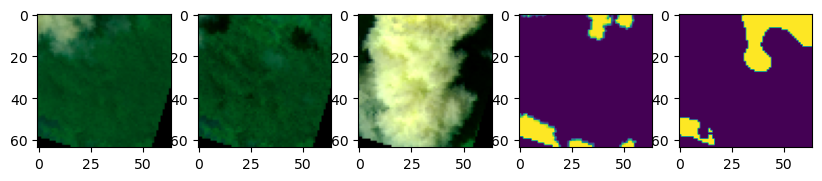

Loss: 1.2984:   3%|▎         | 300/10001 [00:55<20:37,  7.84it/s]  

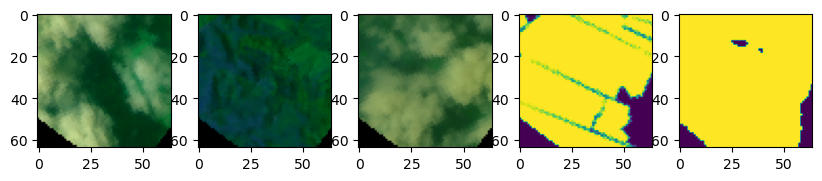

Loss: 0.9806:   4%|▍         | 400/10001 [01:13<19:55,  8.03it/s]  

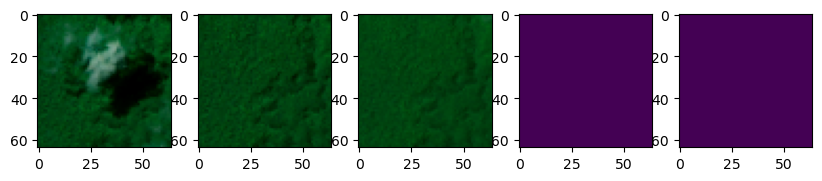

Loss: 1.0511:   5%|▍         | 500/10001 [01:31<20:05,  7.88it/s]  

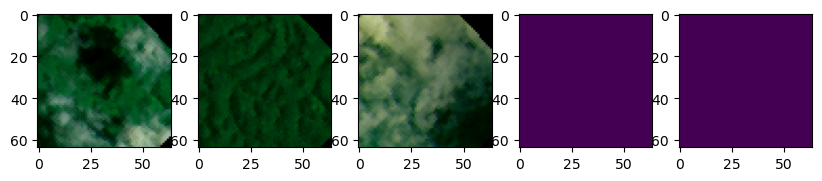

Loss: 1.3568:   6%|▌         | 600/10001 [01:49<19:21,  8.09it/s]  

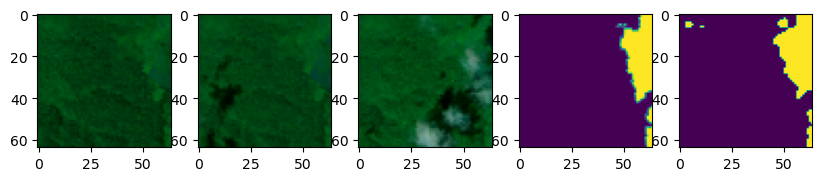

Loss: 1.6272:   7%|▋         | 700/10001 [02:07<18:50,  8.23it/s]  

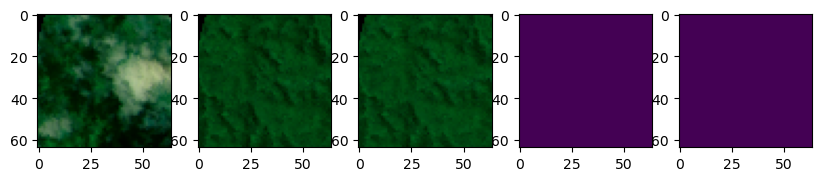

Loss: 1.0868:   8%|▊         | 800/10001 [02:25<19:38,  7.81it/s]  

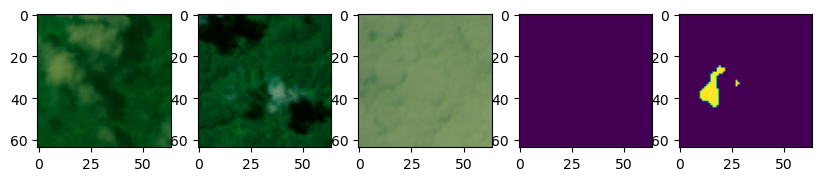

Loss: 1.2045:   9%|▉         | 900/10001 [02:43<18:29,  8.20it/s]  

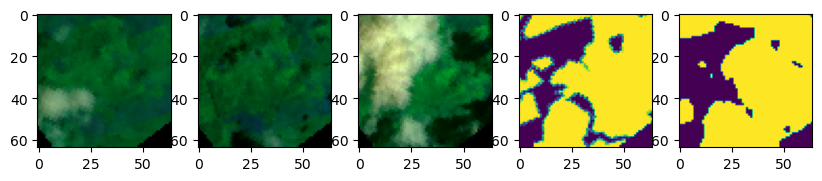

Loss: 1.0629:  10%|▉         | 1000/10001 [03:02<18:35,  8.07it/s] 

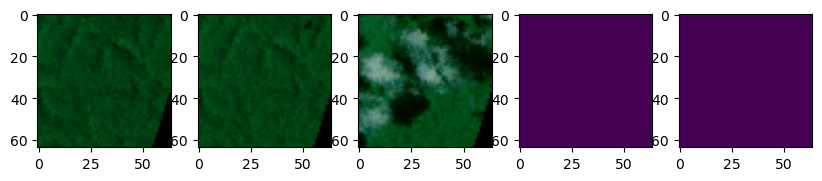

Loss: 0.8394:  11%|█         | 1100/10001 [03:20<18:52,  7.86it/s]  

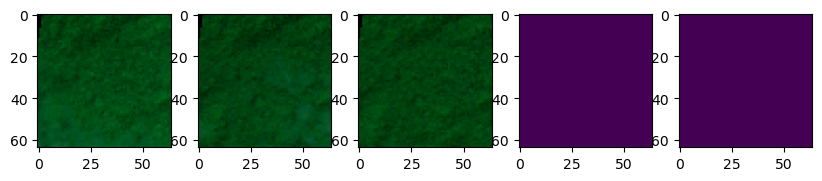

Loss: 0.9200:  12%|█▏        | 1200/10001 [03:38<18:18,  8.01it/s]  

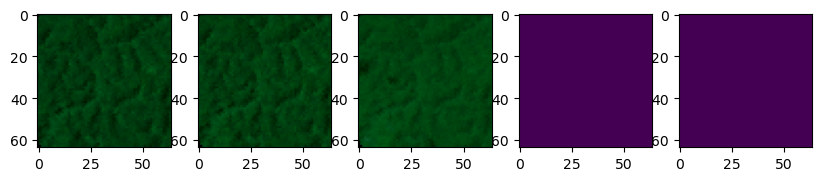

Loss: 1.0193:  13%|█▎        | 1300/10001 [03:57<18:27,  7.86it/s]  

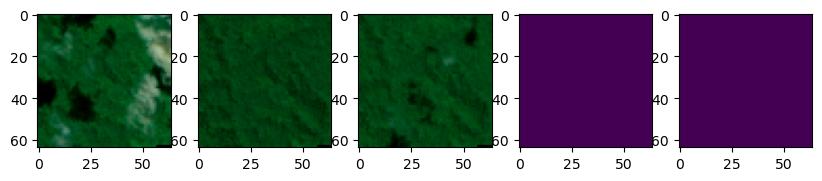

Loss: 1.0110:  14%|█▍        | 1400/10001 [04:15<18:35,  7.71it/s]  

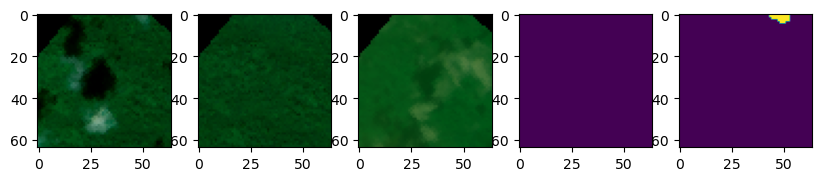

Loss: 0.9285:  15%|█▍        | 1500/10001 [04:34<17:52,  7.93it/s]  

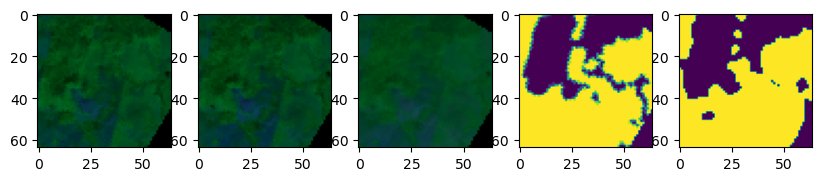

Loss: 1.3068:  16%|█▌        | 1600/10001 [04:52<17:40,  7.92it/s]  

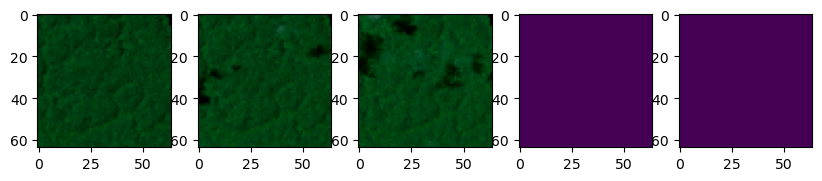

Loss: 1.2167:  17%|█▋        | 1700/10001 [05:10<17:25,  7.94it/s]  

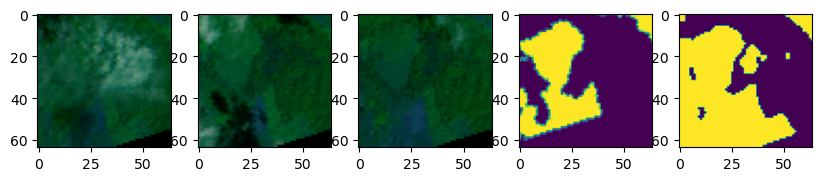

Loss: 1.0058:  18%|█▊        | 1800/10001 [05:28<16:57,  8.06it/s]  

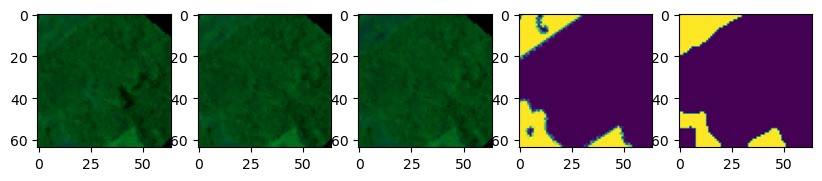

Loss: 1.0775:  19%|█▉        | 1900/10001 [05:46<16:58,  7.96it/s]  

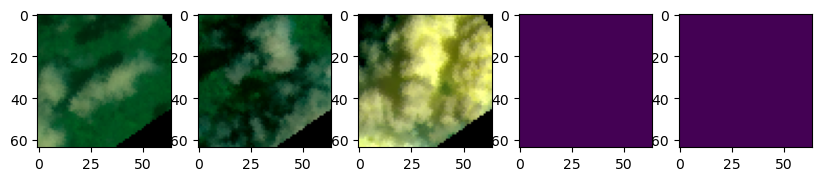

Loss: 0.7369:  20%|█▉        | 2000/10001 [06:04<16:35,  8.04it/s]  

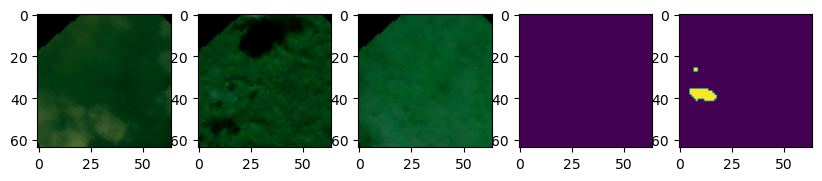

Loss: 0.6758:  21%|██        | 2100/10001 [06:22<15:52,  8.30it/s]  

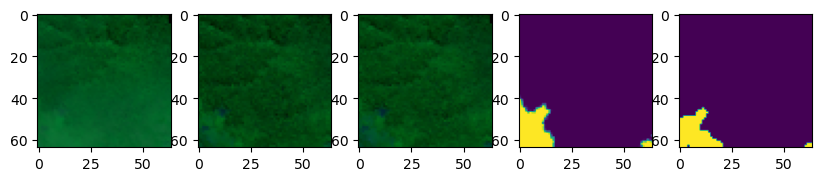

Loss: 0.8606:  22%|██▏       | 2200/10001 [06:40<16:13,  8.01it/s]  

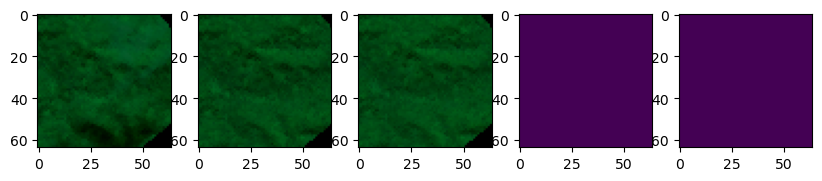

Loss: 1.0198:  23%|██▎       | 2300/10001 [06:58<15:45,  8.14it/s]  

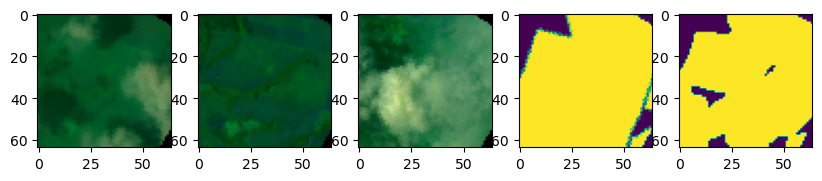

Loss: 0.8901:  24%|██▍       | 2400/10001 [07:16<15:44,  8.05it/s]

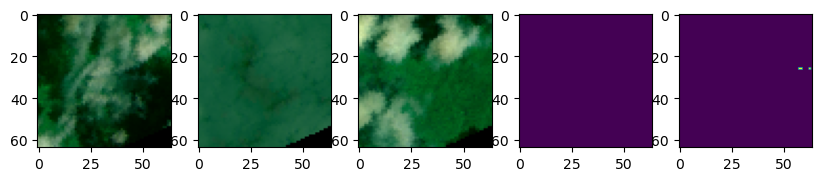

Loss: 0.7919:  25%|██▍       | 2500/10001 [07:35<16:09,  7.74it/s]

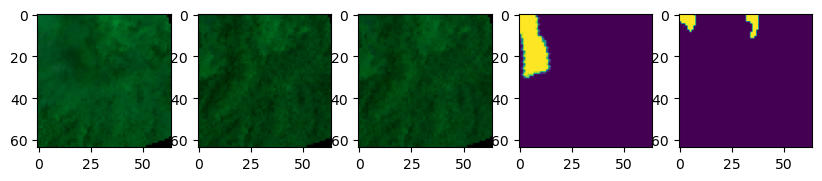

Loss: 0.8403:  26%|██▌       | 2600/10001 [07:53<15:13,  8.11it/s]

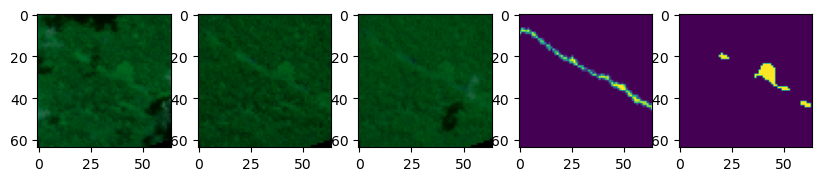

Loss: 0.9955:  27%|██▋       | 2700/10001 [08:11<15:13,  7.99it/s]

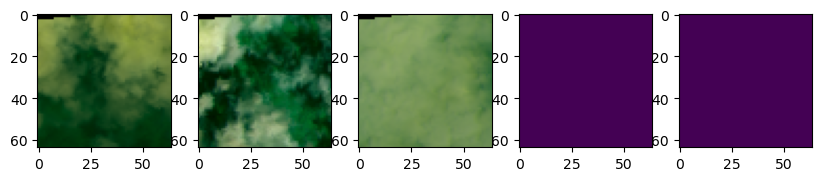

Loss: 0.8137:  28%|██▊       | 2800/10001 [08:29<15:09,  7.92it/s]

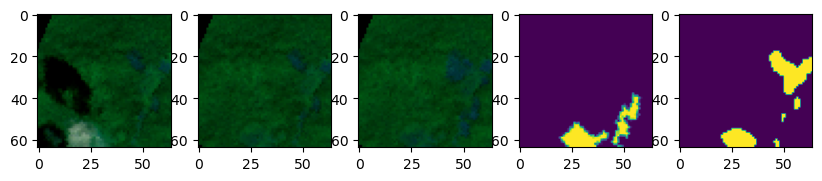

Loss: 0.7637:  29%|██▉       | 2900/10001 [08:47<14:39,  8.07it/s]

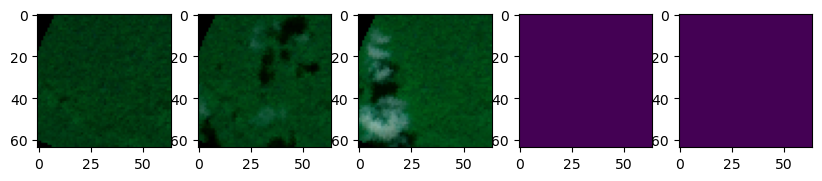

Loss: 1.2997:  30%|██▉       | 3000/10001 [09:05<14:30,  8.05it/s]

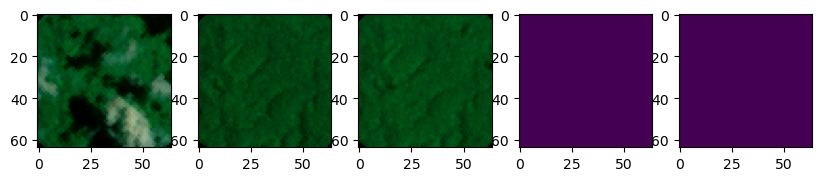

Loss: 0.4517:  31%|███       | 3100/10001 [09:23<14:29,  7.94it/s]

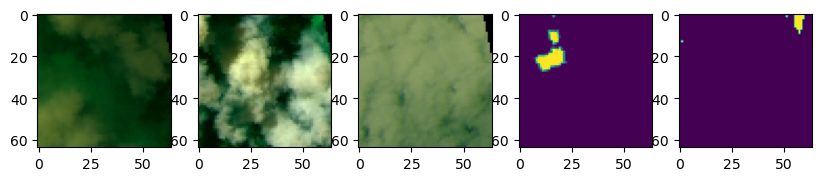

Loss: 0.7200:  32%|███▏      | 3200/10001 [09:41<14:02,  8.07it/s]

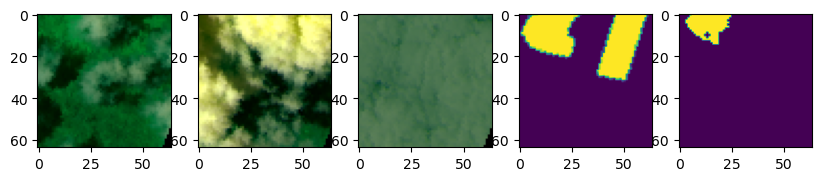

Loss: 0.7880:  33%|███▎      | 3300/10001 [09:59<13:58,  7.99it/s]

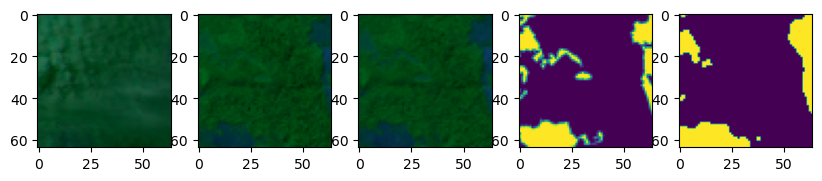

Loss: 0.7880:  33%|███▎      | 3300/10001 [10:01<20:21,  5.48it/s]


KeyboardInterrupt: 

In [8]:
model.train()
loss_fn = bce_ssim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.5e-3, momentum=0.9)

pbar = tqdm(range(10001), miniters=5)
def closure():
    global pbar, optimizer, loss_fn

    optimizer.zero_grad()

    im, lb = next(iter(train_dl))
    lb = lb[:, None, ...]

    out = model(im)
    loss = loss_fn(out, lb).mean()
    
    loss.backward()

    pbar.set_description(f"Loss: {loss:.4f}", refresh=False)
    return loss

val_losses = []
train_losses = []

model.train()
for i in pbar:
    if i == 2500:
        #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = bce_ssim

    if i % 100 == 0:
        with torch.no_grad():
            gc.collect()
            torch.cuda.empty_cache()

            if i % 100 == 0:
                plot_images()
                gc.collect()
                torch.cuda.empty_cache()
            
            val_losses.append(f1_score(val_dl))
            gc.collect()
            torch.cuda.empty_cache()

            train_losses.append(f1_score(test_dl))        
            gc.collect()
            torch.cuda.empty_cache()

    optimizer.step(closure)

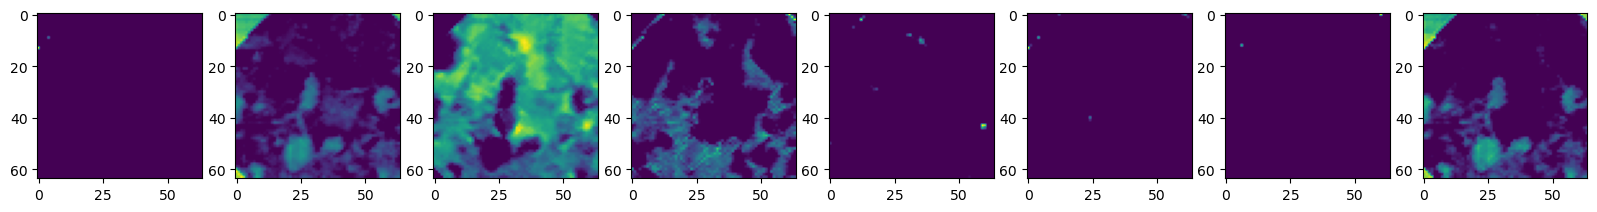

In [ ]:
im, lb = next(iter(train_dl))
lb = lb[:, None, ...]

enc_im = model.enc(im[0][0:8].unsqueeze(0))
enc_im.shape # (1, 8, 64, 64)

fig, axes = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    axes[i].imshow(enc_im[0][i].detach().cpu().numpy())
plt.show()

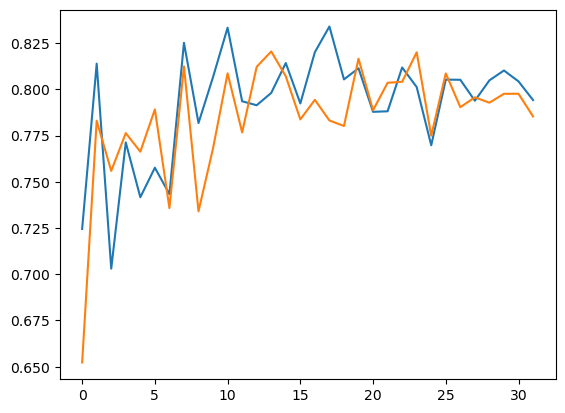

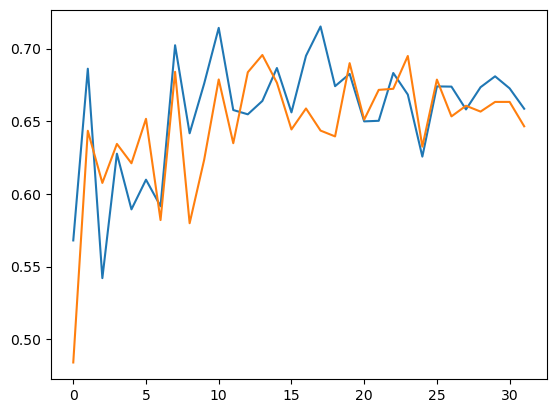

In [32]:
val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

0.8025993764400482


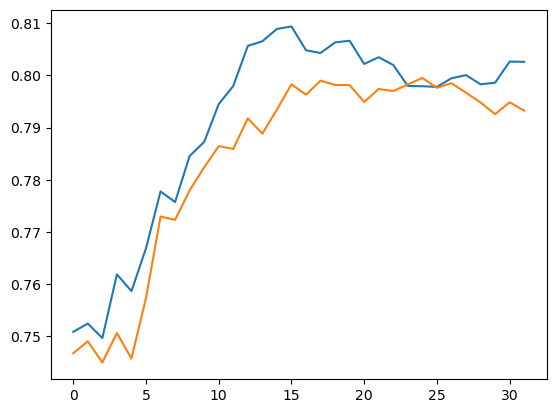

In [33]:
from scipy.ndimage import uniform_filter1d

aa = np.array(val_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)
print(aa[-1])

aa = np.array(train_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)